In [ ]:
pip install alibi[tensorflow]

In [ ]:
pip install anomalib[full]

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict

import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
import tensorflow.keras as keras

from alibi.explainers import CounterfactualRL
from alibi.models.tensorflow import AE
from alibi.models.tensorflow import Actor, Critic
from alibi.explainers.cfrl_base import Callback

from pathlib import Path

from anomalib.data import PredictDataset
from anomalib.engine import Engine
from anomalib.models import Patchcore
import tempfile

from glob import glob
from PIL import Image

CATEGORY = "cable"
BASE_DIR = os.getcwd()
CKPT_PATH = os.path.join(BASE_DIR, "results", "Patchcore", "MVTecAD", CATEGORY, "latest", "weights", "lightning", "model.ckpt")
IMAGE_SIZE = (256, 256)


2025-04-24 10:35:57.627757: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 10:35:57.662646: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-24 10:35:57.662679: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-24 10:35:57.662699: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 10:35:57.669183: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 10:35:57.669787: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [6]:
TEMP_DIR = tempfile.gettempdir()
model = Patchcore()
engine =Engine()

def predictor(X: np.ndarray) -> np.ndarray:
    scores = []
    for i, x in enumerate(X):
        img_path = os.path.join(TEMP_DIR, f"img_{i}.png")
        img = Image.fromarray((x * 255).astype(np.uint8))
        img = img.resize(IMAGE_SIZE)
        img.save(img_path)
        dataset = PredictDataset(path=Path(img_path), image_size=IMAGE_SIZE)
        predictions = engine.predict(model=model, dataset=dataset, ckpt_path=CKPT_PATH)
        score = predictions[0].pred_score
        probs = np.array([1 - score, score]).flatten()  
        scores.append(probs)
        os.remove(img_path)
    result = np.array(scores) 
    return result

INFO:anomalib.models.components.base.anomalib_module:Initializing Patchcore model.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/wide_resnet50_2.racm_in1k)
INFO:timm.models._hub:[timm/wide_resnet50_2.racm_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [23]:
def load_mvtec_images(path, size=(256, 256)):
    image_paths = glob(os.path.join(path, "*.png"))
    data = []
    for img_path in image_paths:
        img = Image.open(img_path).convert("RGB") 
        img = img.resize(size)
        img = np.array(img).astype(np.float32) / 255. 
        data.append(img)
    return np.array(data)

mvtec_root = os.path.join(BASE_DIR, "datasets", "MVTecAD", CATEGORY)
X_train = load_mvtec_images(os.path.join(mvtec_root, "train/good"))
X_test = load_mvtec_images(os.path.join(mvtec_root, "test/good"))
Y_test = load_mvtec_images(os.path.join(mvtec_root, "test/combined"))


In [8]:
BATCH_SIZE = 8
BUFFER_SIZE = 1024

trainset_ae = tf.data.Dataset.from_tensor_slices(X_train)
trainset_ae = trainset_ae.map(lambda x: (x, x))
trainset_ae = trainset_ae.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

testset_ae = tf.data.Dataset.from_tensor_slices(X_test)
testset_ae = testset_ae.map(lambda x: (x, x))
testset_ae = testset_ae.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


2025-04-24 10:36:27.309977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 10:36:27.311308: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
def AnomalyEncoder(latent_dim):
    return keras.Sequential([
        keras.layers.Input(shape=(256, 256, 3)),
        keras.layers.Conv2D(32, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Conv2D(64, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Conv2D(128, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Conv2D(256, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Conv2D(512, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(latent_dim),
    ])

def AnomalyDecoder(latent_dim):
    return keras.Sequential([
        keras.layers.Input(shape=(latent_dim,)),
        keras.layers.Dense(8*8*512),
        keras.layers.Reshape((8, 8, 512)),
        keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid'),
    ])


In [10]:
ae_path = os.path.join("pres", "cable_8_90")
if not os.path.exists(ae_path):
    os.makedirs(ae_path)

LATENT_DIM = 128
EPOCHS = 90

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def mixed_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.5 * mse + 0.5 * (1 - ssim)

ae = AE(encoder=AnomalyEncoder(LATENT_DIM), decoder=AnomalyDecoder(LATENT_DIM))

ae.compile(optimizer=keras.optimizers.Adam(1e-3),
           loss=mixed_loss)

if len(os.listdir(ae_path)) == 0:
    ae.fit(trainset_ae, epochs=EPOCHS)
    ae.save(ae_path)
else:
    ae = keras.models.load_model(ae_path)


Epoch 1/90
28/28 [==============================] - 30s 990ms/step - loss: 0.3494
Epoch 2/90
28/28 [==============================] - 25s 903ms/step - loss: 0.3039
Epoch 3/90
28/28 [==============================] - 24s 852ms/step - loss: 0.2678
Epoch 4/90
28/28 [==============================] - 25s 908ms/step - loss: 0.2634
Epoch 5/90
28/28 [==============================] - 24s 871ms/step - loss: 0.2624
Epoch 6/90
28/28 [==============================] - 24s 872ms/step - loss: 0.2616
Epoch 7/90
28/28 [==============================] - 25s 875ms/step - loss: 0.2610
Epoch 8/90
28/28 [==============================] - 25s 872ms/step - loss: 0.2602
Epoch 9/90
28/28 [==============================] - 25s 879ms/step - loss: 0.2598
Epoch 10/90
28/28 [==============================] - 24s 869ms/step - loss: 0.2596
Epoch 11/90
28/28 [==============================] - 25s 877ms/step - loss: 0.2592
Epoch 12/90
28/28 [==============================] - 25s 886ms/step - loss: 0.2594
Epoch 13/90
2

INFO:tensorflow:Assets written to: pres/cable_8_90/assets


INFO:tensorflow:Assets written to: pres/cable_8_90/assets


1/1 [==============================] - 0s 263ms/step


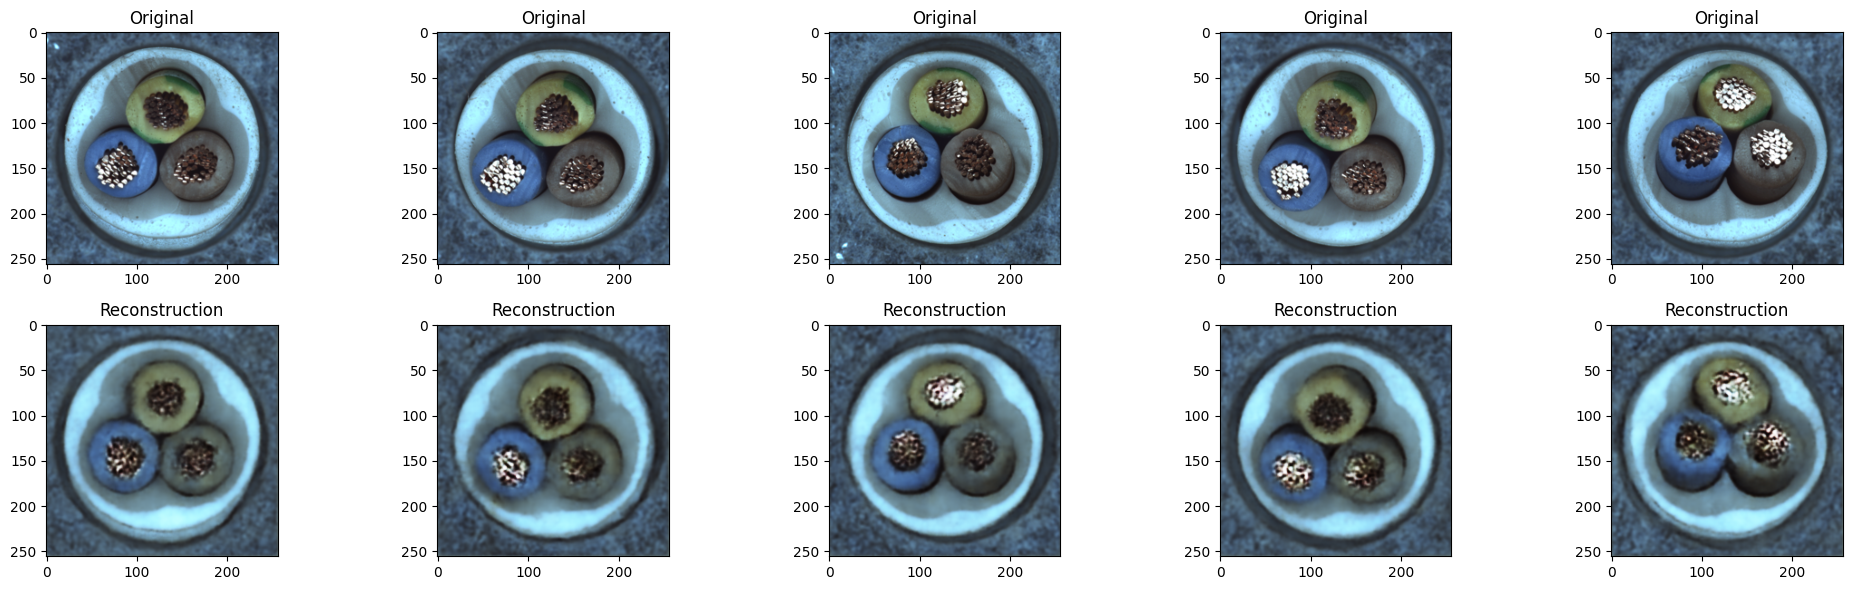

In [11]:
import matplotlib.pyplot as plt

num_samples = 5
samples = X_test[:num_samples]
recons = ae.predict(samples)

fig, ax = plt.subplots(2, num_samples, figsize=(20, 6))
for i in range(num_samples):
    ax[0, i].imshow(samples[i].squeeze())
    ax[0, i].set_title("Original")
    ax[1, i].imshow(recons[i].squeeze())
    ax[1, i].set_title("Reconstruction")
plt.tight_layout()
plt.show()

In [12]:
# Define constants
COEFF_SPARSITY = 7.5               # sparisty coefficient
COEFF_CONSISTENCY = 0              # consisteny coefficient -> no consistency
TRAIN_STEPS = 500                # number of training steps -> consider increasing the number of steps
BATCH_SIZE = 10                  # batch size

In [13]:
# Define explainer.
explainer = CounterfactualRL(predictor=predictor,
                             encoder=ae.encoder,
                             decoder=ae.decoder,
                             latent_dim=LATENT_DIM,
                             coeff_sparsity=COEFF_SPARSITY,
                             coeff_consistency=COEFF_CONSISTENCY,
                             train_steps=TRAIN_STEPS,
                             batch_size=BATCH_SIZE,
                             backend="tensorflow")

In [ ]:
explainer = explainer.fit(X=X_train)

In [ ]:
explanation = explainer.explain(Y_test[0:10], Y_t=np.array([0]), batch_size=5)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

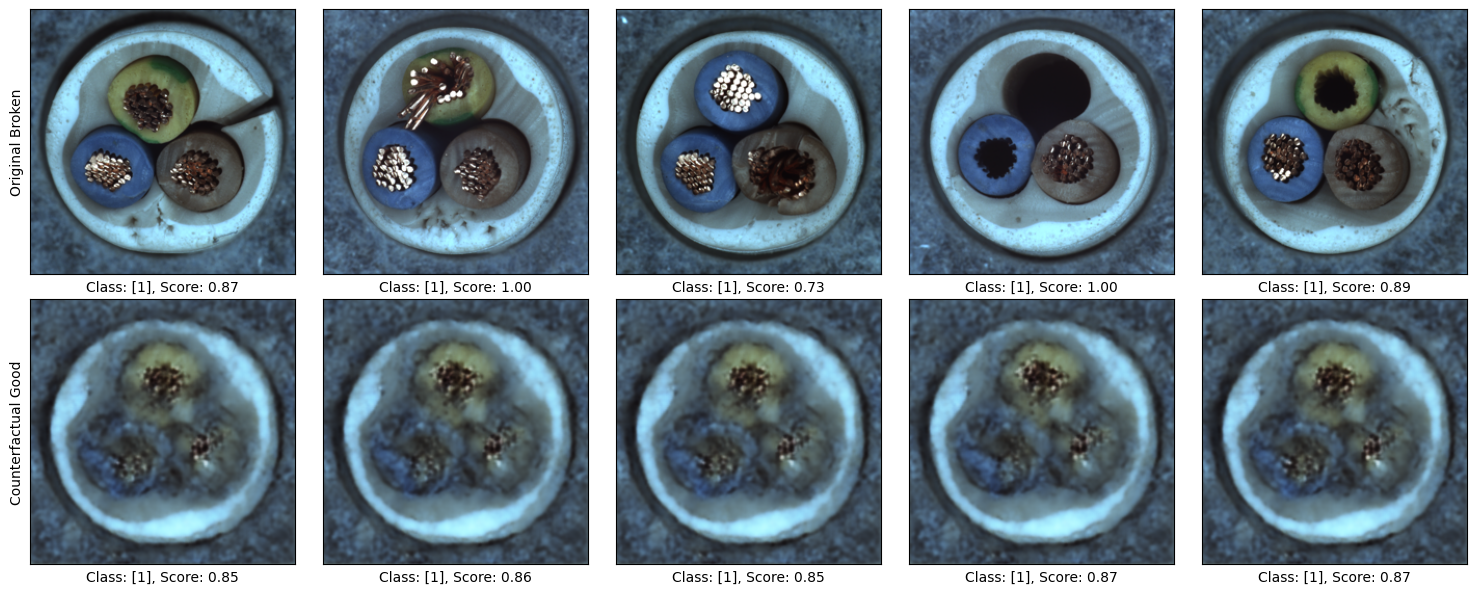

In [24]:
NUM_SAMPLES = 5
fig, ax = plt.subplots(2, NUM_SAMPLES, figsize=(NUM_SAMPLES*3, 6))

for i in range(NUM_SAMPLES):
    orig_probs = predictor(Y_test[0:NUM_SAMPLES])
    cf_probs = predictor(explanation.data['cf']['X'][0:NUM_SAMPLES])

    ax[0][i].imshow(np.clip(explanation.data['orig']['X'][i], 0, 1))
    orig_score = orig_probs[i][1]  # Anomaly score
    orig_class = explanation.data['orig']['class'][i]
    ax[0][i].set_xlabel(f"Class: {orig_class}, Score: {orig_score:.2f}")
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])

    ax[1][i].imshow(np.clip(explanation.data['cf']['X'][i], 0, 1))
    cf_score = cf_probs[i][1]
    cf_class = explanation.data['cf']['class'][i]
    ax[1][i].set_xlabel(f"Class: {cf_class}, Score: {cf_score:.2f}")
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])

ax[0][0].set_ylabel("Original Broken")
ax[1][0].set_ylabel("Counterfactual Good")

plt.tight_layout()
plt.show()